<a href="https://colab.research.google.com/github/tmgrgg/nlp-mafiascum/blob/master/LSTM_Mafiascum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#We'll need this to be able to cache stuff without blowing up RAM

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!git clone https://bitbucket.org/bopjesvla/thesis.git
!mv thesis/src/* .

fatal: destination path 'thesis' already exists and is not an empty directory.
mv: cannot stat 'thesis/src/*': No such file or directory


In [0]:
import pandas as pd
import numpy as np

DOCS_PATH = 'drive/My Drive/24h_of_deception_basic.pkl'

docs = pd.read_pickle(DOCS_PATH)
docs = docs.sample(frac=1)

print(len(docs))

112523


In [0]:
GPU_IS_BREAKING = False

if GPU_IS_BREAKING:
  WORD_LIMIT = 5000
  docs = docs[docs['words'].apply(len) < WORD_LIMIT]

In [0]:
import torch

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Build Dataset


In [0]:
from torchtext import data

class DataFrameDataset(data.Dataset):

    def __init__(self, df, text_field, label_field, **kwargs):
        fields = [('text', text_field), ('label', label_field), ('index', Field(sequential=False, use_vocab=False))]
        examples = []
        for i, row in df.iterrows():
            label = row.scum 
            text = row.words
            examples.append(data.Example.fromlist([text, label, i], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

import torch
from torchtext.data import Field, LabelField

# define Fields
TEXT = Field(sequential=True, include_lengths=True)
LABEL = LabelField(dtype=torch.float)
#LABEL = LabelField(dtype=torch.long)

# define Dataset
dataset = DataFrameDataset(docs, TEXT, LABEL)

import random

train_data, test_data = dataset.split(split_ratio=0.8)
train_data, valid_data = train_data.split(split_ratio = 0.8, random_state= random.seed(SEED))

# Specify Model

In [0]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

# TRAINING

## Training Utilities

In [0]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [0]:
from sklearn.metrics import roc_auc_score, average_precision_score

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    all_predictions = []
    all_y_true = []
    
    for batch in iterator:       
        optimizer.zero_grad()

        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
                
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        all_predictions.append(predictions.cpu().detach().numpy())
        all_y_true.append(batch.label.cpu().detach().numpy())

    
    all_y_true = np.hstack(all_y_true)
    all_predictions = np.hstack(all_predictions)
    auc_score = roc_auc_score(all_y_true, all_predictions)   
    ap_score = average_precision_score(all_y_true, all_predictions) 
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator), auc_score, ap_score

In [0]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        all_predictions = []
        all_y_true = []
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)        
                
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            all_predictions.append(predictions.cpu().numpy())
            all_y_true.append(batch.label.cpu().numpy())

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    all_y_true = np.hstack(all_y_true)
    all_predictions = np.hstack(all_predictions)
    auc_score = roc_auc_score(all_y_true, all_predictions)   
    ap_score = average_precision_score(all_y_true, all_predictions)  
    return epoch_loss / len(iterator), epoch_acc / len(iterator), auc_score, ap_score

In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import OrderedDict

class StatsTracker():
  def __init__(self, plot_freq=5):
    self.counter = 0
    self.plot_freq = plot_freq
    self._metrics = OrderedDict({})

  def _make_plot(self):
      fig, ax = plt.subplots(1, len(self._metrics.keys()), squeeze=False, figsize=(18,4))
      for i, metric in enumerate(self._metrics.keys()):
        train_metric = self._metrics[metric]['train']
        valid_metric = self._metrics[metric]['valid']
        ax[0, i].plot(list(range(len(train_metric))), train_metric, c='b', label='Train', marker='.')
        ax[0, i].plot(list(range(len(valid_metric))), valid_metric, c='r', label='Valid', marker='.')
        ax[0, i].set_ylabel(metric)
        ax[0, i].set_xlabel('epochs')
        ax[0, i].legend(loc='upper right')

  def plot(self):
    # will plot the current loss_graph every plot_freq^th call to plot
    self.counter += 1
    print('eyo')
    print(self.counter)
    print(self.counter % self.plot_freq)
    if (self.counter % self.plot_freq == 0):
      print('hey')
      fig = self._make_plot()
      clear_output()
      plt.show()
      #fig.close()

  def save(self, path):
    # save the current loss_graph to the given path
    self._make_plot()
    plt.savefig(path)
    plt.close()

  def log(self, value, metric, setting='train'):
    assert(setting == 'train' or setting == 'valid')
    if metric not in self._metrics.keys():
      self._metrics[metric] = {'train': [], 'valid': []}
    self._metrics[metric][setting].append(value)

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Define Model Paramters and Training Hyperparameters

In [0]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = True
DROPOUT = 0
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

model.embedding.weight.data.copy_(pretrained_embeddings)
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

torch.Size([25002, 100])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [ 1.8463, -0.3315, -1.5640,  ...,  1.4021, -0.9135, -1.3111],
        [-0.0647,  0.0606,  0.3090,  ...,  0.0614,  1.1674,  0.6288],
        [ 0.0464,  0.1875, -0.7104,  ..., -0.0671, -0.4671, -0.6276]])


In [0]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())#, lr=0.001, weight_decay=0.002)

pos_weight = len(docs[docs['scum'] == False])/len(docs[docs['scum'] == True])

print(pos_weight)

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([pos_weight]))
#criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

3.2006570351289803


## Training Loop

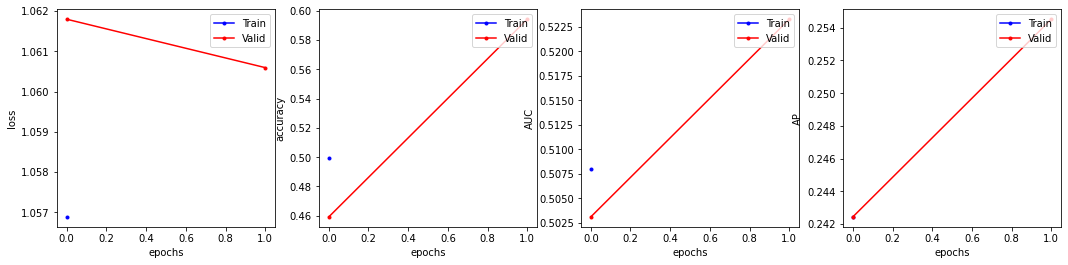

Epoch: 01 | Epoch Time: 1m 11s
	Train Loss: 1.057 | Train Acc: 49.97% | Train AUC: 0.508 | Train AP: 0.242
	 Val. Loss: 1.061 |  Val. Acc: 59.43% | Val. AUC: 0.523 | Val. AP: 0.255


In [0]:
N_EPOCHS = 50

best_valid_loss = float('inf')
tracker = StatsTracker(plot_freq=1)
valid_loss, valid_acc, valid_auc, valid_ap = evaluate(model, valid_iterator, criterion)
tracker.log(valid_loss, 'loss', setting='valid')
tracker.log(valid_acc, 'accuracy', setting='valid')
tracker.log(valid_auc, 'AUC', setting='valid')
tracker.log(valid_ap, 'AP', setting='valid')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc, train_auc, train_ap = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, valid_auc, valid_ap = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')

    tracker.log(train_loss, 'loss', setting='train')
    tracker.log(valid_loss, 'loss', setting='valid')
    tracker.log(train_acc, 'accuracy', setting='train')
    tracker.log(valid_acc, 'accuracy', setting='valid')
    tracker.log(train_auc, 'AUC', setting='train')
    tracker.log(valid_auc, 'AUC', setting='valid')
    tracker.log(train_ap, 'AP', setting='train')
    tracker.log(valid_ap, 'AP', setting='valid')
    tracker.plot()

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Train AUC: {train_auc:.3f} | Train AP: {train_ap:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | Val. AUC: {valid_auc:.3f} | Val. AP: {valid_ap:.3f}')


## Check Performance on Test Set

In [0]:
model.load_state_dict(torch.load('best-lstm.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')